# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [226]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [227]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [228]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [229]:
query_main="""
    select TO_TIMESTAMP(year || '-' || month || '-' || day || ' ' || hour || ':' || min, 'YYYY-MM-DD HH24:MI') AT TIME ZONE 'UTC' as ts,
    gridimport_wh - gridexport_wh as net_load  
    from agg.t_msb1m  
    where site = 64
"""
df_main = pd.read_sql_query(query_main, conn)


C:\Users\Zóra\AppData\Local\Temp\ipykernel_28936\4074366065.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_main = pd.read_sql_query(query_main, conn)


In [230]:
pd.set_option('display.max_columns', None)

df_main

,ts,net_load
0,2019-03-01 00:00:00,10.680
1,2019-03-01 00:15:00,7.320
2,2019-03-01 00:30:00,7.410
3,2019-03-01 00:45:00,7.630
4,2019-03-01 01:00:00,8.140
...,...,...
38048,2020-03-31 22:45:00,7.510
38049,2020-03-31 23:00:00,7.370
38050,2020-03-31 23:15:00,7.570
38051,2020-03-31 23:30:00,6.810


In [231]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38053 entries, 0 to 38052
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ts        38053 non-null  datetime64[ns]
 1   net_load  38053 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 594.7 KB


## Convert Convert 'ts' to datetime and set as index

In [232]:
df_main['datetime'] = pd.to_datetime(df_main['ts'])
df_main.set_index('datetime', inplace=True)

In [264]:
df_main

,ts,net_load,net_load_norm
datetime,,,
2019-03-01 00:00:00,2019-03-01 00:00:00,10.680,0.010541
2019-03-01 00:15:00,2019-03-01 00:15:00,7.320,0.007225
2019-03-01 00:30:00,2019-03-01 00:30:00,7.410,0.007313
2019-03-01 00:45:00,2019-03-01 00:45:00,7.630,0.007531
2019-03-01 01:00:00,2019-03-01 01:00:00,8.140,0.008034
...,...,...,...
2020-03-31 22:45:00,2020-03-31 22:45:00,7.510,0.007412
2020-03-31 23:00:00,2020-03-31 23:00:00,7.370,0.007274
2020-03-31 23:15:00,2020-03-31 23:15:00,7.570,0.007471


In [234]:
#df_main['net_load_norm'] = df_main['net_load'] / max(abs(df_main['net_load']))
#df_main.drop('net_load',axis=1,inplace=True)
#df_main.head()

### Creating function for lagged net_load

In [265]:
#Creating function for lagged net_load

def create_lagged_features(df, lags):
    df_lagged = df.copy()
    for lag in lags:
        df_lagged[f'net_load_lag_{lag}'] = df_lagged['net_load_norm'].shift(lag)
    # Remove rows with NaN values due to shifting
    df_lagged = df_lagged.dropna()
    return df_lagged

# Define your lags
lags = [1,2,3,96,192]

# Prepare your dataset with lagged features
df_lagged = create_lagged_features(df_main, lags)

df_lagged

,ts,net_load,net_load_norm,net_load_lag_1,net_load_lag_2,net_load_lag_3,net_load_lag_96,net_load_lag_192
datetime,,,,,,,,
2019-03-03 00:00:00,2019-03-03 00:00:00,21.590,0.021309,0.017983,0.017598,0.018387,0.008379,0.010541
2019-03-03 00:15:00,2019-03-03 00:15:00,42.580,0.042025,0.021309,0.017983,0.017598,0.007442,0.007225
2019-03-03 00:30:00,2019-03-03 00:30:00,42.370,0.041818,0.042025,0.021309,0.017983,0.007669,0.007313
2019-03-03 00:45:00,2019-03-03 00:45:00,25.860,0.025523,0.041818,0.042025,0.021309,0.007373,0.007531
2019-03-03 01:00:00,2019-03-03 01:00:00,17.180,0.016956,0.025523,0.041818,0.042025,0.008557,0.008034
...,...,...,...,...,...,...,...,...
2020-03-31 22:45:00,2020-03-31 22:45:00,7.510,0.007412,0.007343,0.007412,0.007106,0.007333,0.007412
2020-03-31 23:00:00,2020-03-31 23:00:00,7.370,0.007274,0.007412,0.007343,0.007412,0.006771,0.007304
2020-03-31 23:15:00,2020-03-31 23:15:00,7.570,0.007471,0.007274,0.007412,0.007343,0.007462,0.007205


#### get_input function

In [236]:
#def get_input(ts, lags):
    # Assumes `ts` is a pandas Series
    #return ts[[-1 - lag for lag in lags]].values.reshape(1, -1)

# A function that will prepare the feature vector for a single prediction 
# by selecting the appropriate lagged values from the time series data

#get_input(df_main['net_load'], lags)

In [237]:
def get_input(ts, lags):
    # Convert lags to positions from the end of the series
    positions = [len(ts) - 1 - lag for lag in lags]
    # Use iloc to get values at positions
    return ts.iloc[positions].values.reshape(1, -1)

#### Create a function that performs sequential predictions over a specified number of steps, using each prediction as input for the next

In [238]:

#def rolling_window_predictions(model, full_series, test_series, lags):
    #"""
    #Generate rolling window predictions and plot against actual data.
    
    #:param model: The pre-trained machine learning model.
    #:param full_series: Complete time series data, containing both training and test data.
    #:param test_series: Series containing the test data with actual values to compare against.
    #:param lags: List of integers representing the lag intervals.
    #"""
    # Initialize the initial time series for rolling predictions
    #initial_ts = full_series[-max(lags):]
    
    # Store the out-of-sample predictions
    #predictions = []
    
    # Iterate over the test set to predict one step ahead each time
    #for actual_value in test_series:
        # Get the input features for the current prediction
        #input_features = get_input(initial_ts, lags).reshape(1, -1)
        
        # Predict the next time step and store the prediction
        #pred = model.predict(input_features)[0]
        #predictions.append(pred)
        
        # Append the actual observed value to roll the window forward
        #initial_ts = pd.concat([initial_ts, pd.Series([actual_value])], ignore_index=True)
        
        # Ensure that initial_ts only contains the most recent data needed for the next prediction
        #if len(initial_ts) > max(lags):
            #initial_ts = initial_ts.tail(max(lags))
    
    # Plot the actual vs predicted data
    #plt.figure(figsize=(15, 7))
    #plt.plot(test_series.index, test_series, label='Actual Data', color='blue')
    #plt.plot(test_series.index, predictions, label='Rolling Window Predictions', color='red', linestyle='--')
    #plt.legend()
    #plt.xlabel('Date Time')
    #plt.ylabel('Net Load')
    #plt.title('Rolling Window Predictions vs Actual Data')
    #plt.show()
    
    #return predictions

In [239]:
#def rolling_prediction(model, initial_ts, steps_ahead, lags):
    # 'initial_ts' is expected to be a Pandas Series with enough past observations to cover all lags.
    # initial_ts needs to be a series with at least 192 past observations.
    #HOW DO I MAKE SURE THSI IS THE CASE? I only have now lags 1,2,3,96,192
    #ts = initial_ts.copy()
    #predictions = []

    #for i in range(steps_ahead):
        # Get the input for the current prediction.
        # Ensure that 'get_input' retrieves the last known observations from 'ts'
        # for all required lags.
        #input_features = get_input(ts, lags)
        
        # Predict the next step using the RF model.
        #pred = model.predict(input_features)[0]
        
        # Append the prediction to the list of predictions.
        #predictions.append(pred)
        
        # Also append the prediction to 'ts' for subsequent predictions.
        # The 'ts' will now include the most recent prediction at the end.
        #ts = ts.append(pd.Series(pred), ignore_index=True)
        
    # Return only the predictions made, not the entire series.
    #return predictions

#### Create initial_ts by taking the last 192 observations from this point backward to cover all lags

In [266]:
# Assuming 'df_main' has a DateTimeIndex and 'net_load' is your target column.

# Identify the time point for initial_ts
end_time = df_main.index[-1]
start_time = end_time - pd.Timedelta(hours=48)  # 192 intervals of 15 minutes is equivalent to 48 hours

# Make sure you don't go out of bounds
if start_time < df_main.index[0]:
    raise ValueError("Not enough data points for the required lags.")

# Create initial_ts for rolling predictions
# We select the data between 'start_time' and 'end_time', including all necessary lags.
initial_ts = df_main.loc[start_time:end_time]['net_load_norm']

In [241]:
initial_ts

datetime
2020-03-29 23:45:00    10.435715
2020-03-30 00:00:00     7.230000
2020-03-30 00:15:00     7.740000
2020-03-30 00:30:00     7.720000
2020-03-30 00:45:00     7.260000
                         ...    
2020-03-31 22:45:00     7.510000
2020-03-31 23:00:00     7.370000
2020-03-31 23:15:00     7.570000
2020-03-31 23:30:00     6.810000
2020-03-31 23:45:00     9.225000
Name: net_load, Length: 193, dtype: float64

### Define features and target, train and test

In [276]:
# Define features and target
y = df_lagged['net_load_norm']
X = df_lagged[[f'net_load_lag_{lag}' for lag in lags]]

# Split data into training and testing sets
#train_size = int(len(df_lagged) * 0.8)
#train_features, test_features = X.iloc[:train_size], X.iloc[train_size:]
#train_target, test_target = y.iloc[:train_size], y.iloc[train_size:]

# Reserve the last 96 observations for testing
train_features = X.iloc[:-192]
test_features = X.iloc[-192:]

train_target = y.iloc[:-192]
test_target = y.iloc[-192:]

### Model definition and training 

In [277]:
rf = RandomForestRegressor()

# TRAIN the model
rf.fit(train_features, train_target)

# TEST the model - Predict on the test set - Make predictions for the test set
y_pred = rf.predict(test_features)


In [278]:
# error metric MAE and normalized MAE
mae = mean_absolute_error(test_target, y_pred)
print(f'Mean Absolute Error: {mae}')

target_range = train_target.max() -train_target.min()
normalized_mae = mae / target_range
print(f'Normalized MAE: {normalized_mae}')

Mean Absolute Error: 0.03400183446936978
Normalized MAE: 0.020436398448385268


In [279]:
input_features = get_input(train_target, lags)
pred = rf.predict(input_features)

print(input_features)
print(pred)

[[0.0072049  0.0072049  0.00730359 0.00730359 0.00726411]]
[0.00941226]


C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [280]:
initial_ts

datetime
2020-03-29 23:45:00    0.010300
2020-03-30 00:00:00    0.007136
2020-03-30 00:15:00    0.007639
2020-03-30 00:30:00    0.007619
2020-03-30 00:45:00    0.007165
                         ...   
2020-03-31 22:45:00    0.007412
2020-03-31 23:00:00    0.007274
2020-03-31 23:15:00    0.007471
2020-03-31 23:30:00    0.006721
2020-03-31 23:45:00    0.009105
Name: net_load_norm, Length: 193, dtype: float64

### Rolling origin prediction for 1 day ahead

In [281]:

def rolling_window_predictions(model, full_series, test_series, lags):
    """
    Generate rolling window predictions and plot against actual data.
    
    :model: pre-trained RF
    :full_series: COMPLETE time series data with both training and test data
    :test_series: series containing the TEST data with actual values to compare against
    :param lags: List of integers representing the lag intervals.
    """
    initial_ts = full_series[-max(lags):] # Initial time series for rolling predictions    
    predictions = []  # Store out-of-sample predictions
    
    for actual_value in test_series: # Iterate over the test set to predict one step ahead each time
        
        input_features = get_input(initial_ts, lags).reshape(1, -1) # Get the input features for the current prediction
        
        pred = model.predict(input_features)[0] # Predict the next time step and store the prediction
        predictions.append(pred)
        
        # Append the actual observed value to roll the window forward
        initial_ts = pd.concat([initial_ts, pd.Series([actual_value])], ignore_index=True)
        
        # Ensure that initial_ts only contains the most recent data needed for the next prediction
        if len(initial_ts) > max(lags):
            initial_ts = initial_ts.tail(max(lags))
    
    # Plot the actual vs predicted data
    plt.figure(figsize=(15, 7))
    plt.plot(test_series.index, test_series, label='Actual Data', color='blue')
    plt.plot(test_series.index, predictions, label='Rolling Window Predictions', color='red', linestyle='--')
    plt.legend()
    plt.xlabel('Date Time')
    plt.ylabel('Normalised Net Load')
    plt.title('Rolling Window Predictions vs Actual Data')
    plt.show()
    
    return predictions

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:

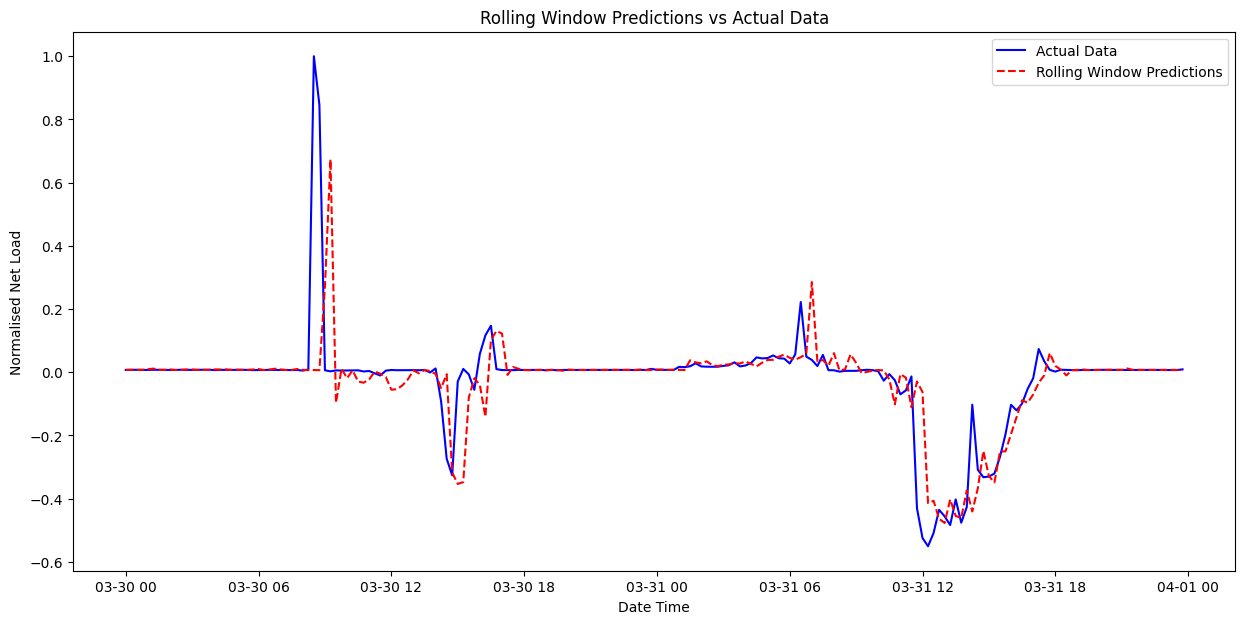

In [283]:
predicted_values = rolling_window_predictions(rf, df_main['net_load_norm'], test_target, lags=[1,2,3,96,192])


### Rolling origin prediction for multiple steps ahead

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:

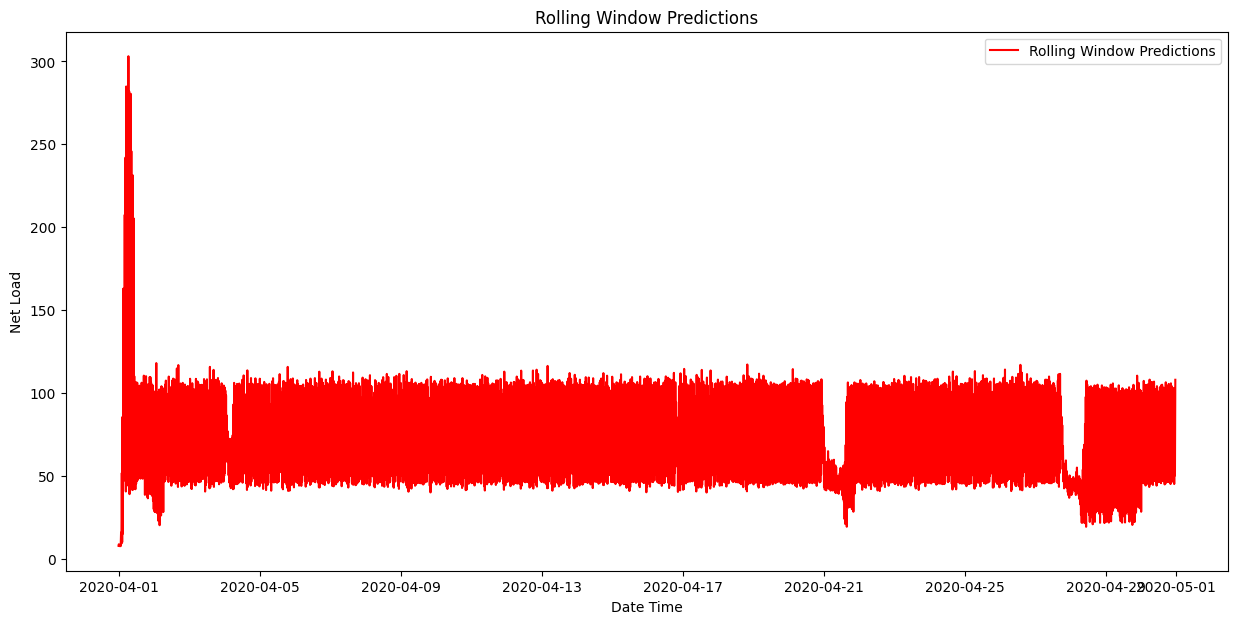

In [249]:
import pandas as pd
import matplotlib.pyplot as plt

def rolling_window_predictions(model, full_series, steps_ahead, lags):
    """
    Generate rolling window predictions for a specified number of steps ahead.

    :param model: The pre-trained machine learning model.
    :param full_series: Complete time series data, containing both training and (optionally) test data.
    :param steps_ahead: Number of future steps to predict.
    :param lags: List of integers representing the lag intervals.
    :return: A tuple (predictions, prediction_series) containing the list of prediction values and
             the corresponding pandas Series with timestamps.
    """
    # Initialize the initial time series for rolling predictions
    initial_ts = full_series[-max(lags):]
    
    # Store the out-of-sample predictions
    predictions = []
    
    # Iterate to predict the specified number of steps ahead
    for step in range(steps_ahead):
        # Get the input features for the current prediction
        input_features = get_input(initial_ts, lags).reshape(1, -1)
        
        # Predict the next time step and store the prediction
        pred = model.predict(input_features)[0]
        predictions.append(pred)
        
        # Append the predicted value to roll the window forward
        initial_ts = pd.concat([initial_ts, pd.Series([pred])], ignore_index=True)
        
        # Ensure that initial_ts only contains the most recent data needed for the next prediction
        if len(initial_ts) > max(lags):
            initial_ts = initial_ts.tail(max(lags))
    
    # Generate the datetime index for the prediction series
    last_timestamp = full_series.index[-1]
    prediction_index = pd.date_range(start=last_timestamp, periods=steps_ahead, freq='15T')
    
    # Create the prediction series
    prediction_series = pd.Series(data=predictions, index=prediction_index)

    # Plot the prediction series
    plt.figure(figsize=(15, 7))
    plt.plot(prediction_series.index, prediction_series, label='Rolling Window Predictions', color='red')
    plt.legend()
    plt.xlabel('Date Time')
    plt.ylabel('Net Load')
    plt.title('Rolling Window Predictions')
    plt.show()
    
    return predictions, prediction_series

# Usage example:
# rf_model - your pre-trained RandomForestRegressor
# df_main['net_load'] - the full series including training data
# steps_ahead - how far into the future you want to predict
# lags - the lags used for predictions

# Example call to the function:
predicted_values, prediction_series = rolling_window_predictions(rf, df_main['net_load'], steps_ahead=30*24*4, lags=[1,2,3,96,192])


C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:

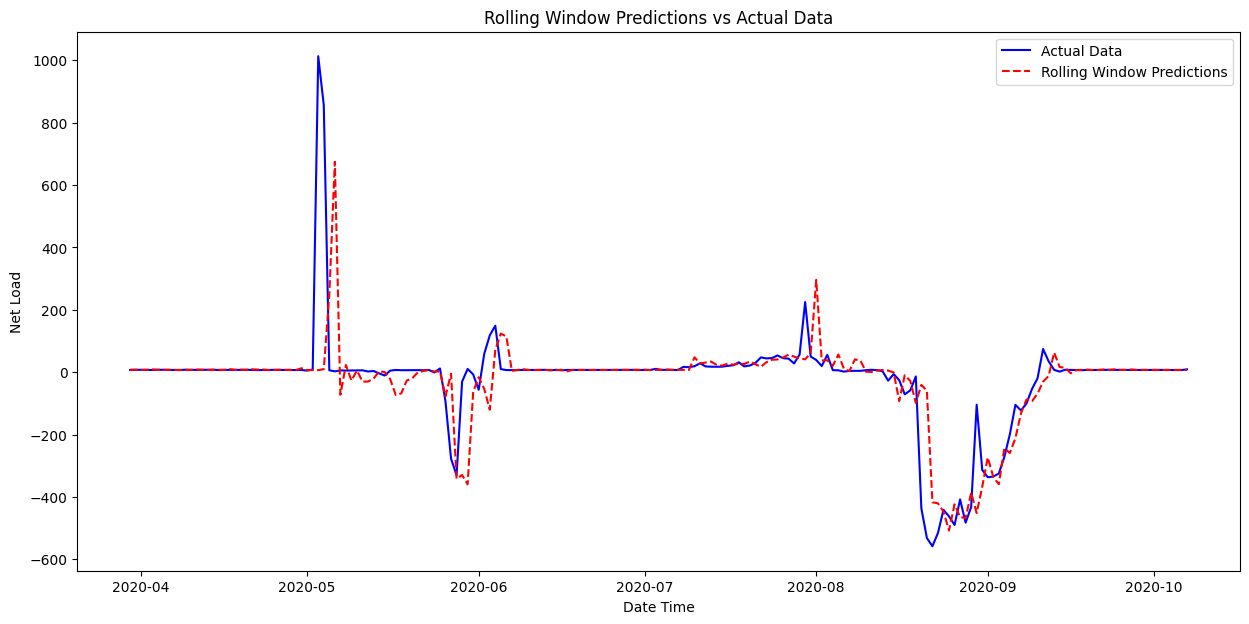

In [250]:
def rolling_window_predictions_steps(model, full_series, test_series, lags, steps_ahead):
    """
    Generate rolling window predictions for a specified number of steps ahead and plot against actual data.
    
    :param model: The pre-trained machine learning model.
    :param full_series: Complete time series data, containing both training and test data.
    :param test_series: Series containing the test data with actual values to compare against.
    :param lags: List of integers representing the lag intervals.
    :param steps_ahead: Integer, number of future steps to predict.
    """
    # Initialize the initial time series for rolling predictions
    initial_ts = full_series[-max(lags):]
    
    # Store the out-of-sample predictions
    predictions = []
    
    # Use a counter to keep track of the number of steps predicted
    steps_predicted = 0
    
    # Iterate over the test set to predict one step ahead each time
    for actual_value in test_series:
        if steps_predicted >= steps_ahead:
            break  # Stop prediction if we reached the desired number of steps
        
        # Get the input features for the current prediction
        input_features = get_input(initial_ts, lags).reshape(1, -1)
        
        # Predict the next time step and store the prediction
        pred = model.predict(input_features)[0]
        predictions.append(pred)
        
        # Append the actual observed value to roll the window forward
        initial_ts = pd.concat([initial_ts, pd.Series([actual_value])], ignore_index=True)
        
        # Ensure that initial_ts only contains the most recent data needed for the next prediction
        if len(initial_ts) > max(lags):
            initial_ts = initial_ts.tail(max(lags))
        
        # Increment the counter
        steps_predicted += 1
    
    # Generate an index for the predicted values (assuming test_series has a DateTime index)
    predicted_index = pd.date_range(start=test_series.index[0], periods=steps_predicted, freq=test_series.index.freq)
    
    # Plot the actual vs predicted data up to the steps ahead
    plt.figure(figsize=(15, 7))
    plt.plot(predicted_index, test_series[:steps_predicted], label='Actual Data', color='blue')
    plt.plot(predicted_index, predictions, label='Rolling Window Predictions', color='red', linestyle='--')
    plt.legend()
    plt.xlabel('Date Time')
    plt.ylabel('Net Load')
    plt.title('Rolling Window Predictions vs Actual Data')
    plt.show()
    
    return predictions

# Example call to the function with steps_ahead parameter:
predicted_values = rolling_window_predictions_steps(
    rf, df_main['net_load'], test_target, lags=[1,2,3,96,192], steps_ahead=720  # For example, 720 steps of 15 minutes each
)


Trial for rolling window - but ending up just being prediction 

C:\Users\Zóra\AppData\Local\Temp\ipykernel_28936\3399072566.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  prediction_index = pd.date_range(start=last_timestamp, periods=24, freq='15T')


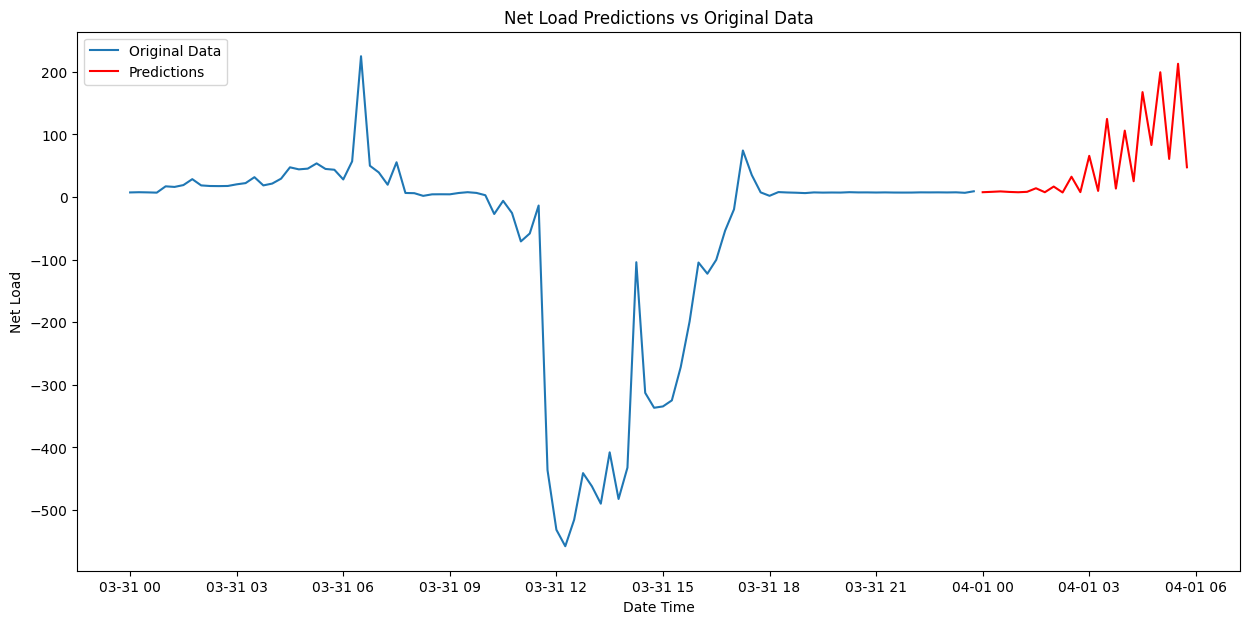

In [251]:
# The frequency '15T' is used because your data is in 15-minute intervals
last_timestamp = df_main.index[-1] + pd.Timedelta(minutes=15)
prediction_index = pd.date_range(start=last_timestamp, periods=24, freq='15T')

# Create a series for the predictions with the new time index
prediction_series = pd.Series(data=rf_predictions, index=prediction_index)

# Combine original data and the predictions into a single DataFrame
combined_data = pd.concat([df_main['net_load'], prediction_series])

plt.figure(figsize=(15, 7))
plt.plot(df_main.index[-96:], df_main['net_load'][-96:], label='Original Data')  # Last 96 points (24 hours if data is 15-min intervals)
plt.plot(prediction_series.index, prediction_series, label='Predictions', color='red')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Net Load')
plt.title('Net Load Predictions vs Original Data')
plt.show()

C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\Zóra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:

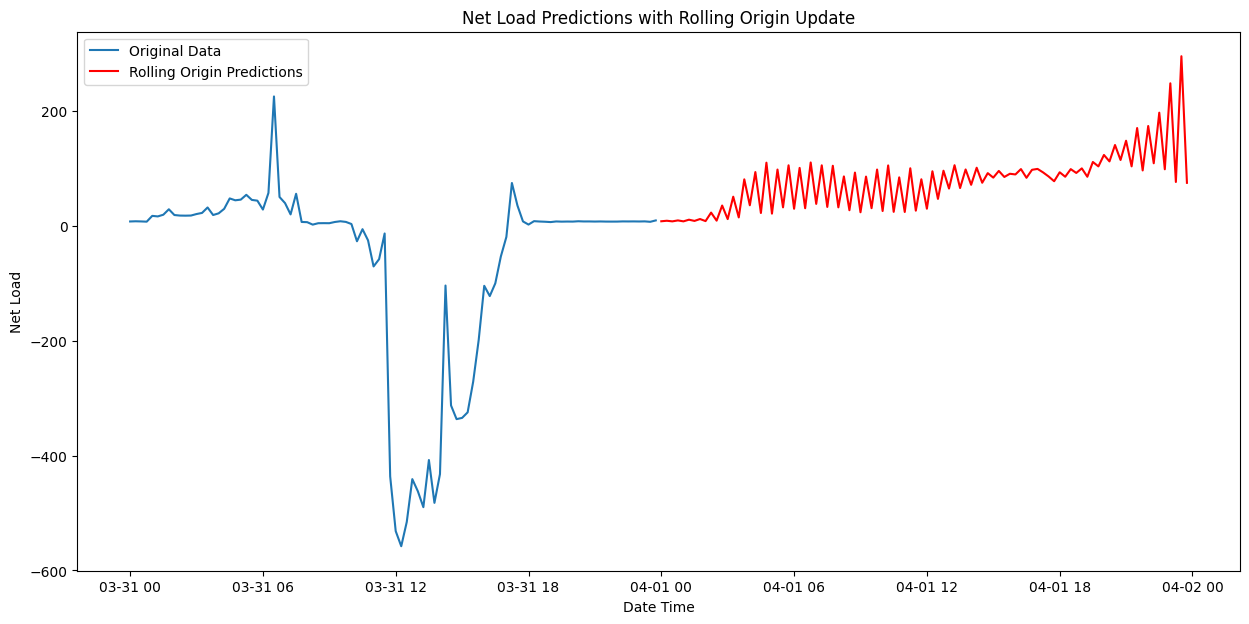

In [252]:
# Initialize the initial time series for rolling predictions
# This should contain the actual data up to the point where you start predictions
initial_ts = df_main.loc[start_time:end_time]['net_load']

# List to store each prediction
rolling_predictions = []

# Assuming rf is your trained model and get_input is defined as before
for i in range(96):  # Replace with the number of 15-min intervals you want to predict
    # Get the input for the current prediction
    input_features = get_input(initial_ts, lags).reshape(1, -1)
    
    # Predict the next time step
    pred = rf.predict(input_features)[0]
    
    # Store the prediction
    rolling_predictions.append(pred)
    
    # Update the initial time series with the prediction
    # This 'rolls' the origin for the next prediction
    initial_ts = pd.concat([initial_ts, pd.Series([pred])], ignore_index=True)

    # Ensure that initial_ts only contains the most recent data needed for the next prediction
    if len(initial_ts) > max(lags):
        initial_ts = initial_ts.tail(max(lags))  # Keep only the required number of most recent observations

# Convert predictions to a pandas Series with a new time index starting after the last original timestamp
last_timestamp = df_main.index[-1]
predicted_index = pd.date_range(start=last_timestamp + pd.Timedelta(minutes=15), periods=len(rolling_predictions), freq='15T')
prediction_series = pd.Series(data=rolling_predictions, index=predicted_index)

# Plotting the original and predicted data
plt.figure(figsize=(15, 7))
plt.plot(df_main.index[-96:], df_main['net_load'][-96:], label='Original Data')  # Plot last 96 points (24 hours if data is in 15-min intervals)
plt.plot(prediction_series.index, prediction_series, label='Rolling Origin Predictions', color='red')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Net Load')
plt.title('Net Load Predictions with Rolling Origin Update')
plt.show()


In [253]:
get_input(df_main['net_load'], lags)
get_input(ts, lags)

NameError: name 'ts' is not defined

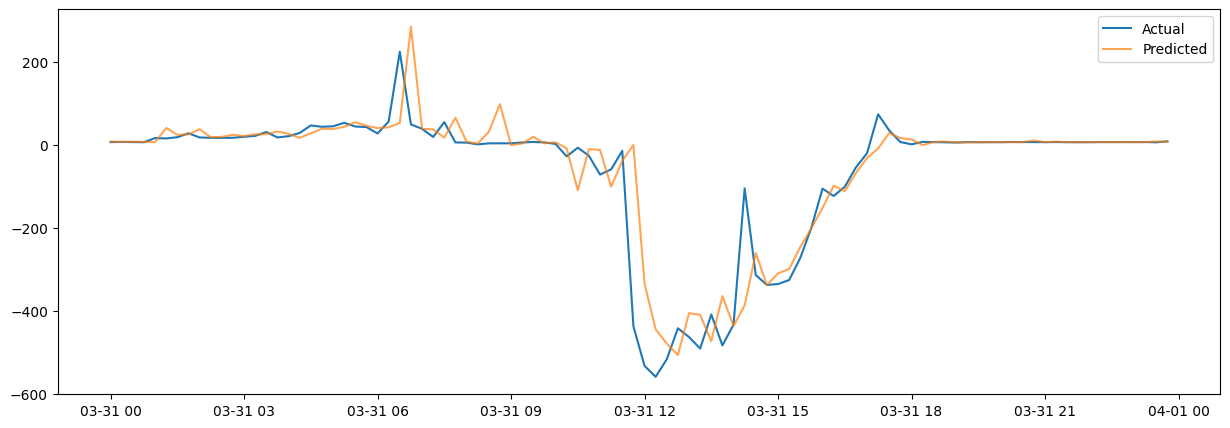

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test_target.index, test_target, label='Actual')
plt.plot(test_target.index, y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
initial_ts

datetime
2020-03-29 23:45:00    10.435715
2020-03-30 00:00:00     7.230000
2020-03-30 00:15:00     7.740000
2020-03-30 00:30:00     7.720000
2020-03-30 00:45:00     7.260000
                         ...    
2020-03-31 22:45:00     7.510000
2020-03-31 23:00:00     7.370000
2020-03-31 23:15:00     7.570000
2020-03-31 23:30:00     6.810000
2020-03-31 23:45:00     9.225000
Name: net_load, Length: 193, dtype: float64